In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

In [2]:
# Variables and functions from other files
ACCURACY_KEY = 'accuracy'
BYTES_WRITTEN_KEY = 'bytes_written'
BYTES_READ_KEY = 'bytes_read'
LOCAL_COMPUTATIONS_KEY = 'local_computations'
NUM_ROUND_KEY = 'round_number'
NUM_SAMPLES_KEY = 'num_samples'
CLIENT_ID_KEY = 'client_id'

def _weighted_mean(df, metric_name, weight_name):
    d = df[metric_name]
    w = df[weight_name]
    try:
        return (w * d).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [3]:
# Function to get list of test accuracy from all clients
def getLogs(directory, starts_with):
    
    all_files = []
    for file in os.listdir(directory):
        all_files.append(directory + '/' + file)
    
    selected_files = []
    for log_file in all_files:
        if log_file.startswith(starts_with):
            selected_files.append(log_file)
    
    return(selected_files)

In [4]:
# Function to summarize test accuracy on each communication round
def get_accuracy(stat_metrics_file):
    stat_metrics = pd.read_csv(stat_metrics_file) if stat_metrics_file else None
    if stat_metrics is not None:
        stat_metrics.sort_values(by=NUM_ROUND_KEY, inplace=True)

    accuracies = stat_metrics.groupby(NUM_ROUND_KEY)
    accuracies = accuracies.apply(_weighted_mean, ACCURACY_KEY, NUM_SAMPLES_KEY)

    return(accuracies)

In [5]:
# Function to summarize bytes sent on each communication round
def get_bytes(sys_metrics_file, rolling_window=1000):
    
    # Load the data
    sys_metrics = pd.read_csv(sys_metrics_file)
    
    # Preprocess the data
    server_metrics = sys_metrics.groupby(NUM_ROUND_KEY, as_index=False).sum()
    server_metrics['bytes_written'] = server_metrics['bytes_written'] / 1073741824
    server_metrics['bytes_read'] = server_metrics['bytes_read'] / 1073741824
    server_metrics = server_metrics.rolling(rolling_window, on=NUM_ROUND_KEY, min_periods=1).sum()

    return(server_metrics)

In [6]:
# Function to create smooth version of the test accuracy trend line
def smoothMetric(metric, step):

    newMetric = []
    for index in range(0, len(metric), step):
        newMetric.append(metric[index])

    return(newMetric)

# Model Performance Analysis

In [7]:
# Get the log files of MNIST dataset
logFiles = getLogs('mnist', 'mnist/stat')
logFiles

['mnist/stat_metrics-B-10-E-1.csv',
 'mnist/stat_metrics-B-10-E-5.csv',
 'mnist/stat_metrics-B-50-E-1.csv',
 'mnist/stat_metrics-B-50-E-5.csv',
 'mnist/stat_metrics-B-600-E-1.csv',
 'mnist/stat_metrics-B-600-E-5.csv']

### Increasing computation

In [8]:
# Get test accuracy trend of different hyperparameter settings
accuracies_B10_E1 = get_accuracy(logFiles[0]).tolist()
accuracies_B10_E5 = get_accuracy(logFiles[1]).tolist()
accuracies_B50_E1 = get_accuracy(logFiles[2]).tolist()
accuracies_B50_E5 = get_accuracy(logFiles[3]).tolist()
accuracies_B600_E1 = get_accuracy(logFiles[4]).tolist()
accuracies_B600_E5 = get_accuracy(logFiles[5]).tolist()

In [9]:
# Create smooth version of the test accuracy over communcation rounds
accuracies_B10_E1 = smoothMetric(accuracies_B10_E1, 20)
accuracies_B10_E5 = smoothMetric(accuracies_B10_E5, 20)
accuracies_B50_E1 = smoothMetric(accuracies_B50_E1, 20)
accuracies_B50_E5 = smoothMetric(accuracies_B50_E5, 20)
accuracies_B600_E1 = smoothMetric(accuracies_B600_E1, 20)
accuracies_B600_E5 = smoothMetric(accuracies_B600_E5, 20)

In [10]:
# Find total number of communcation needed to achieve the target accuracy
#next(x[0] for x in enumerate(accuracies_B600_E1) if x[1] >= 0.7) + 1
print(next(x[0] for x in enumerate(accuracies_B600_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E5) if x[1] >= 0.7) + 1)

30
15
13
9
6


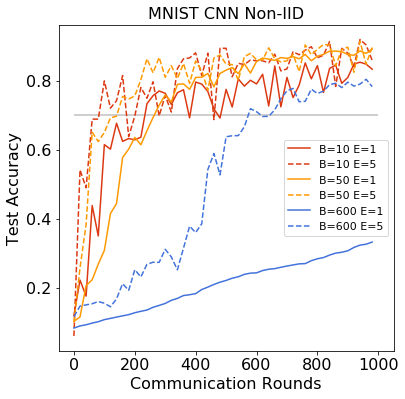

In [11]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(6, 6))
plt.title('MNIST CNN Non-IID', fontsize=16)
plt.plot(accuracies_B10_E1, label='B=10 E=1', c='#dc3912')
plt.plot(accuracies_B10_E5, label='B=10 E=5', c='#dc3912', ls='--')
plt.plot(accuracies_B50_E1, label='B=50 E=1', c='#ff9900')
plt.plot(accuracies_B50_E5, label='B=50 E=5', c='#ff9900', ls='--')
plt.plot(accuracies_B600_E1, label='B=600 E=1', c='#4272db')
plt.plot(accuracies_B600_E5, label='B=600 E=5', c='#4272db', ls='--')
plt.hlines(0.7, 0, 50, colors='gray', alpha=0.5)
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Communication Rounds", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=16)
plt.legend(fontsize=11);

### Increasing parallelism

In [12]:
# Get the log files of MNIST dataset
logFiles = getLogs('2nn', '2nn/stat')
logFiles

['2nn/stat_metrics-C-00.csv',
 '2nn/stat_metrics-C-01.csv',
 '2nn/stat_metrics-C-02.csv',
 '2nn/stat_metrics-C-05.csv']

In [13]:
# Get test accuracy trend of different hyperparameter settings
accuracies_C00 = get_accuracy(logFiles[0]).tolist()
accuracies_C01 = get_accuracy(logFiles[1]).tolist()
accuracies_C02 = get_accuracy(logFiles[2]).tolist()
accuracies_C05 = get_accuracy(logFiles[3]).tolist()

In [14]:
# Create smooth version of the test accuracy over communcation rounds
accuracies_C00 = smoothMetric(accuracies_C00, 20)
accuracies_C01 = smoothMetric(accuracies_C01, 20)
accuracies_C02 = smoothMetric(accuracies_C02, 20)
accuracies_C05 = smoothMetric(accuracies_C05, 20)

In [15]:
# Find total number of communcation needed to achieve the target accuracy
#next(x[0] for x in enumerate(accuracies_B600_E1) if x[1] >= 0.7) + 1
print(next(x[0] for x in enumerate(accuracies_C00) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C01) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C02) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_C05) if x[1] >= 0.7) + 1)

11
7
6
6


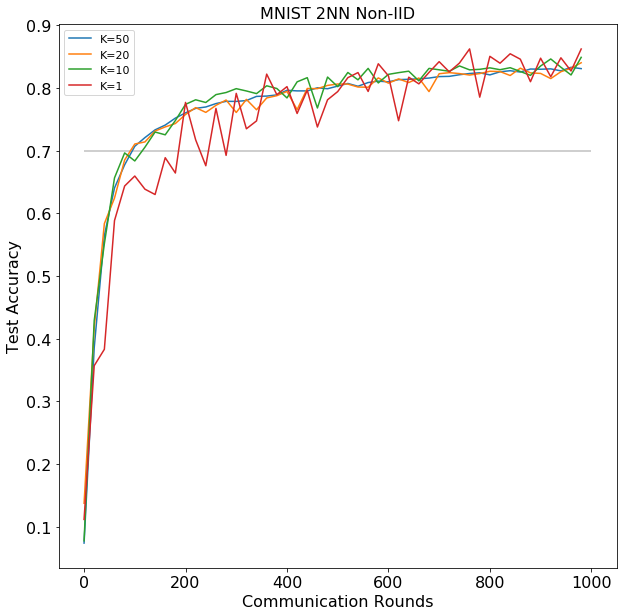

In [16]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(10, 10))
plt.title('MNIST 2NN Non-IID', fontsize=16)
plt.plot(accuracies_C05, label='K=50')
plt.plot(accuracies_C02, label='K=20')
plt.plot(accuracies_C01, label='K=10')
plt.plot(accuracies_C00, label='K=1')
plt.hlines(0.7, 0, 50, colors='gray', alpha=0.5)
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'), fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Communication Rounds", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=16)
plt.legend(fontsize=11);

# Communcation Cost Analysis

In [17]:
# Get the log files of MNIST dataset
logFiles = getLogs('2nn', '2nn/sys')
logFiles

['2nn/sys_metrics-C-00.csv',
 '2nn/sys_metrics-C-01.csv',
 '2nn/sys_metrics-C-02.csv',
 '2nn/sys_metrics-C-05.csv']

In [18]:
# Get bytes send trend of different hyperparameter settings
bytes_C00 = get_bytes(logFiles[0])
bytes_C01 = get_bytes(logFiles[1])
bytes_C02 = get_bytes(logFiles[2])
bytes_C05 = get_bytes(logFiles[3])

In [19]:
# Configuration
rounds = get_bytes(logFiles[0]).index.values
figsize = (10, 8)
title_fontsize = 16

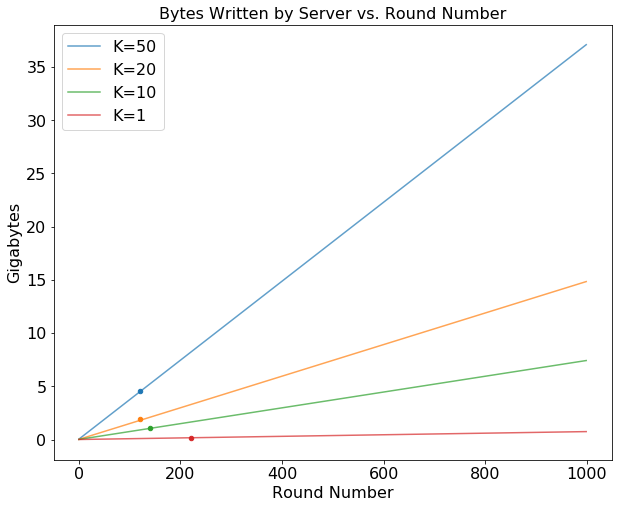

In [20]:
plt.figure(figsize=figsize)

plt.plot(rounds, bytes_C05['bytes_written'], label='K=50', alpha=0.7)
plt.plot(rounds, bytes_C02['bytes_written'], label='K=20', alpha=0.7)
plt.plot(rounds, bytes_C01['bytes_written'], label='K=10', alpha=0.7)
plt.plot(rounds, bytes_C00['bytes_written'], label='K=1', alpha=0.7)

plt.scatter(20*6, 4.6, s=20)
plt.scatter(20*6, 1.9, s=20)
plt.scatter(20*7, 1.1, s=20)
plt.scatter(20*11, 0.16, s=20)

plt.title('Bytes Written by Server vs. Round Number', fontsize=title_fontsize)
plt.xlabel('Round Number', fontsize=title_fontsize)
plt.ylabel('Gigabytes', fontsize=title_fontsize)
plt.xticks(fontsize=title_fontsize)
plt.yticks(fontsize=title_fontsize)
plt.legend(fontsize=title_fontsize)
plt.show()

In [21]:
print(bytes_C05.loc[6*20, 'bytes_written'])
print(bytes_C02.loc[6*20, 'bytes_written'])
print(bytes_C01.loc[7*20, 'bytes_written'])
print(bytes_C00.loc[11*20, 'bytes_written'])

4.489796236157417
1.795918494462967
1.046382263302803
0.16400743275880814
